In [1]:
%pip install langchain openai transformers --quiet
%pip install -U langchain-openai --quiet
%pip install torch torchvision torchaudio --quiet
%pip install -U langchain-community --quiet
%pip install ipywidgets --quiet
%pip install pandas --quiet
%pip install scikit-learn --quiet
%pip install matplotlib Pillow --quiet

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import pandas as pd
from PIL import Image as PILImage
from PIL import Image, ImageEnhance, ImageFilter
from transformers import CLIPProcessor, CLIPModel
import torch
from langchain.agents import initialize_agent
from langchain_openai import ChatOpenAI
from langchain.schema import HumanMessage
from langchain.tools import BaseTool
from sentence_transformers import SentenceTransformer, util
import chromadb
import base64
from chromadb.utils.embedding_functions import OpenCLIPEmbeddingFunction
from chromadb.utils.data_loaders import ImageLoader
from IPython.display import Image, display, Markdown
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import joblib

In [3]:
# Set the OpenAI API key
os.environ["OPENAI_API_KEY"] = "sk-proj-uRoYTQ11Qi4yndbUFWSOT3BlbkFJ5dcSHgZPnJRjSpXUwRU7"

# Initialise ChatGPT
# gpt4o = ChatOpenAI(temperature=0, model_name="gpt-4o")
gpt4o = ChatOpenAI(temperature=0, model_name="gpt-4o")

# Initialise CLIP model and processor
clip_model_name = "openai/clip-vit-base-patch32"
clip_processor = CLIPProcessor.from_pretrained(clip_model_name)
clip_model = CLIPModel.from_pretrained(clip_model_name)

# Initialise the ChromaDB client
chroma_client = chromadb.PersistentClient(path="./image_vdb")

# Initialise ChromaDB Image Loader
image_loader = ImageLoader()
image_loader._PILImage = PILImage

# Initialize CLIP embedding
CLIP = OpenCLIPEmbeddingFunction()
# Create a database of image vectors
image_vdb = chroma_client.get_or_create_collection(name="image", embedding_function=CLIP, data_loader=image_loader)

# Initialise the PCA model and downscale the feature vector to 128 dimensions
pca = PCA(n_components=128)

In [4]:
# Image Preprocessing Functions
def preprocess_image(image_path):
    image = PILImage.open(image_path).convert('RGB')

    # Resizing images
    image = image.resize((224, 224))

    # Enhanced contrast
    enhancer = ImageEnhance.Contrast(image)
    image = enhancer.enhance(2)

    # Denoising
    image = image.filter(ImageFilter.MedianFilter(size=3))

    return image

def extract_image_features(image_path, text):
    # Pre-processed images
    image_object = preprocess_image(image_path)

    # Image feature extraction using CLIP model
    clip_image_inputs = clip_processor(images=image_object, return_tensors="pt")
    clip_text_inputs = clip_processor(text=[text], return_tensors="pt")

    with torch.no_grad():
        clip_image_outputs = clip_model.get_image_features(**clip_image_inputs)
        clip_text_outputs = clip_model.get_text_features(**clip_text_inputs)

    # Normalize the features to have unit norm
    clip_image_outputs = torch.nn.functional.normalize(clip_image_outputs, p=2, dim=-1)
    clip_text_outputs = torch.nn.functional.normalize(clip_text_outputs, p=2, dim=-1)

    # Combine image and text features
    combined_features = (clip_image_outputs + clip_text_outputs) / 2

    # Spreading feature vectors into a one-dimensional list
    image_features = combined_features.flatten().tolist()

    return image_features


In [5]:
def clear_vdb():
    chroma_client.delete_collection(name="image")
    global image_vdb
    image_vdb = chroma_client.get_or_create_collection(
        name="image", 
        embedding_function=CLIP, 
        data_loader=image_loader
    )

def add_images_to_vdb_with_summary(directory_paths, max_images_per_folder=2000):
    ids = []
    uris = []
    all_features = []
    global_id = 0
    for directory_path in directory_paths:
        images_processed = 0
        for filename in sorted(os.listdir(directory_path)):
            if filename.lower().endswith('.jpg'):
                file_path = os.path.join(directory_path, filename)
                text = os.path.basename(os.path.dirname(file_path))
                image_features = extract_image_features(file_path, text)
                all_features.append(image_features)
                
                ids.append(str(global_id))
                uris.append(file_path)
                global_id += 1
                images_processed += 1
                if images_processed >= max_images_per_folder:
                    break
    
    global pca
    if pca is None:
        pca = PCA(n_components=128)
        print("Warning: PCA was not initialized. Initializing now.")
    compressed_features = pca.fit_transform(all_features)
    joblib.dump(pca, 'pca_model.joblib')
    
    # Adding compressed features to the database
    if ids:
        image_vdb.add(ids=ids, uris=uris, embeddings=compressed_features.tolist())
        print(f"Added {len(ids)} images to the database.")

local_image_dirs = [
    r'C:\Users\wanghanyu\Desktop\5_Classes\Fabricated',
    r'C:\Users\wanghanyu\Desktop\5_Classes\Forged',
    r'C:\Users\wanghanyu\Desktop\5_Classes\Other',
    r'C:\Users\wanghanyu\Desktop\5_Classes\Sheet Metal',
    r'C:\Users\wanghanyu\Desktop\5_Classes\Turned'
]

clear_vdb()

add_images_to_vdb_with_summary(local_image_dirs)
print("Image count in VDB:", image_vdb.count())

Added 10000 images to the database.
Image count in VDB: 10000


In [6]:
def query_db_with_summary(image_path, text, results=3, top_k=500):
    query_features = extract_image_features(image_path, text)
    # Compression of query features using the same PCA model
    query_summary_features = pca.transform([query_features])[0]
    try:
        all_results = image_vdb.query(
            query_embeddings=[query_summary_features.tolist()],
            n_results=top_k + 1,
            include=['uris', 'distances']
        )
    except Exception as e:
        print(f"Error querying the database: {e}")
        return None
    
    filtered_results = filter_results(all_results, image_path, top_k=results)
    visualize_results(image_path, filtered_results['uris'])
    return filtered_results

# Result Filter Functions
def filter_results(all_results, image_path, top_k):
    distances_and_uris_and_ids = list(zip(all_results['distances'][0], all_results['uris'][0], all_results['ids'][0]))
    filtered_results = [
        (dist, uri, id) for dist, uri, id in distances_and_uris_and_ids
        if os.path.normpath(uri) != os.path.normpath(image_path) and dist != 0
    ]
    sorted_results = sorted(filtered_results, key=lambda x: x[0])
    unique_results = []
    seen_distances = set()
    for dist, uri, id in sorted_results:
        if dist not in seen_distances:
            unique_results.append((dist, uri, id))
            seen_distances.add(dist)
    final_results = unique_results[:top_k]
    sorted_distances = [dist for dist, _, _ in final_results]
    sorted_uris = [uri for _, uri, _ in final_results]
    sorted_ids = [id for _, _, id in final_results]
    return {
        'ids': sorted_ids,
        'uris': sorted_uris,
        'distances': sorted_distances
    }

# Result Visualisation Functions
def visualize_results(query_image_path, result_uris):
    fig, axs = plt.subplots(2, 2, figsize=(12, 12))
    fig.suptitle('Query Image and Top 3 Results', fontsize=16)

    query_img = PILImage.open(query_image_path).convert('RGB')
    axs[0, 0].imshow(query_img)
    axs[0, 0].set_title('Query Image')
    axs[0, 0].axis('off')

    for i, uri in enumerate(result_uris[:3]):
        img = PILImage.open(uri).convert('RGB')
        row = (i + 1) // 2
        col = (i + 1) % 2
        axs[row, col].imshow(img)
        axs[row, col].set_title(f'Result {i+1}')
        axs[row, col].axis('off')

    plt.tight_layout()
    plt.show()

In [7]:
def format_prompt_inputs(data, user_query, text_info):
    inputs = {}
    inputs['user_query'] = user_query
    inputs['text_info'] = text_info
    
    # Acquire and encode the master image
    image_path_1 = data['uris'][0]
    with open(image_path_1, 'rb') as image_file:
        image_data_1 = image_file.read()
    inputs['image_data_1'] = base64.b64encode(image_data_1).decode('utf-8')
    
    # Extract and include retrieved text information
    retrieved_texts = [os.path.basename(os.path.dirname(uri)) for uri in data['uris']]
    inputs['retrieved_info_texts'] = ', '.join(retrieved_texts)
    
    # Coding retrieved images
    for i, uri in enumerate(data['uris'][:3]):
        print(f"Encoding image {i+1}: {uri}")
        with open(uri, 'rb') as image_file:
            inputs[f'retrieved_info_images_{i}'] = base64.b64encode(image_file.read()).decode('utf-8')
    
    # If fewer than 3 images are retrieved, fill with an empty string
    for i in range(len(data['uris']), 3):
        inputs[f'retrieved_info_images_{i}'] = ''
    
    # Contains retrieved information
    inputs['retrieved_info'] = {
        'uris': data['uris'],
        'distances': data['distances'],
        'texts': retrieved_texts,
    }
    
    return inputs

# Initialise the output parser
parser = StrOutputParser()

image_prompt = ChatPromptTemplate.from_messages([
    ("system", """You are a mechanical engineer specializing in manufacturing processes. Your task is to analyze images of mechanical components, identify their primary manufacturing method, and briefly describe key features of the component.

You will be provided with the main image to analyze, along with up to three similar components retrieved from a database. Your goal is to use the additional images for comparison and to enhance your analysis, providing a more comprehensive and accurate description."""),

    ("user", [
        {"type": "text", "text": """Analyze the main image of the mechanical component and identify its primary manufacturing method and key features.

You have access to up to 3 similar components retrieved from the database, the retrieved images are displayed below.

Consider the similarities and differences between the main image and the retrieved images to provide a more accurate and comprehensive description.

Respond with a concise sentence stating the primary manufacturing method used to produce this component and key features."""},
        {"type": "image_url", "image_url": "data:image/jpeg;base64,{image_data_1}"},
        {"type": "image_url", "image_url": "data:image/jpeg;base64,{retrieved_info_images_0}"},
        {"type": "image_url", "image_url": "data:image/jpeg;base64,{retrieved_info_images_1}"},
        {"type": "image_url", "image_url": "data:image/jpeg;base64,{retrieved_info_images_2}"},
    ]),
])


# Define the LangChain chain
vision_chain = image_prompt | gpt4o | parser


def generate_description_with_rag(image_path):
    try:
        text_info = os.path.basename(os.path.dirname(image_path))
        
        user_query = "Analyze the mechanical component image with reference to similar components."
        
        results = query_db_with_summary(image_path, text_info, results=3)
        print(f"Query results for {image_path}: {results}")
        
        if results is None or len(results['uris']) == 0:
            print(f"Warning: No results retrieved for {image_path}")
            return "Unable to generate description due to lack of similar components."
        
        prompt_input = format_prompt_inputs(results, user_query, text_info)
        
        response = vision_chain.invoke(prompt_input)
        return response
    except Exception as e:
        print(f"Error in generate_description_with_rag for {image_path}: {str(e)}")
        return f"Error generating description: {str(e)}"

In [8]:
# Define a tool class for describing images
class DescribeImageWithDetailsTool(BaseTool):
    name = "Describe Image With Details Tool"
    description = 'Use this tool to describe an images of mechanical parts with additional details.'
    
    def _run(self, image_path: str):
        return self.run(image_path)
    
    def run(self, image_path: str):
        description = generate_description_with_rag(image_path)
        return description

# Initialise tools and agents
tools = [DescribeImageWithDetailsTool()]
agent = initialize_agent(
    agent='chat-conversational-react-description',
    tools=tools,
    llm=gpt4o,
    max_iterations=5,
    early_stopping_method='generate'
)

c:\Users\wanghanyu\.conda\envs\pytorch\lib\site-packages\langchain_core\_api\deprecation.py:139: LangChainDeprecationWarning: The function `initialize_agent` was deprecated in LangChain 0.1.0 and will be removed in 0.3.0. Use Use new agent constructor methods like create_react_agent, create_json_agent, create_structured_chat_agent, etc. instead.
  warn_deprecated(


In [9]:
def process_directories(directory_paths):
    results = []
    for directory_path in directory_paths:
        missing_files = []
        files_processed = 0
        for filename in os.listdir(directory_path):
            if filename.lower().endswith('.jpg'):
                files_processed += 1
                if files_processed > 1:
                    break
                image_path = os.path.join(directory_path, filename)
                print(f"Checking if the file exists: {image_path}")
                if os.path.exists(image_path):
                    try:
                        print(f"Calling agent to process the file: {image_path}")
                        description = generate_description_with_rag(image_path)
                        result = {"image_name": filename, "description": description}
                        results.append(result)
                    except Exception as e:
                        results.append({"image_name": filename, "description": f"Error processing file: {str(e)}"})
                else:
                    print(f"File not found: {image_path}")
                    missing_files.append(filename)
                    results.append({"image_name": filename, "description": "File not found"})
        if missing_files:
            print(f"The following files were not found in {directory_path}: {', '.join(missing_files)}")

    # Save results to a CSV file
    output_file_path = os.path.join(os.getcwd(), "RAG_PCA_vector.csv")
    df = pd.DataFrame(results)
    df.to_csv(output_file_path, index=False)
    print(f"CSV file saved at: {output_file_path}")

    return results

Checking if the file exists: C:\Users\wanghanyu\Desktop\5_Classes\Fabricated\Fabricated_1.jpg
Calling agent to process the file: C:\Users\wanghanyu\Desktop\5_Classes\Fabricated\Fabricated_1.jpg


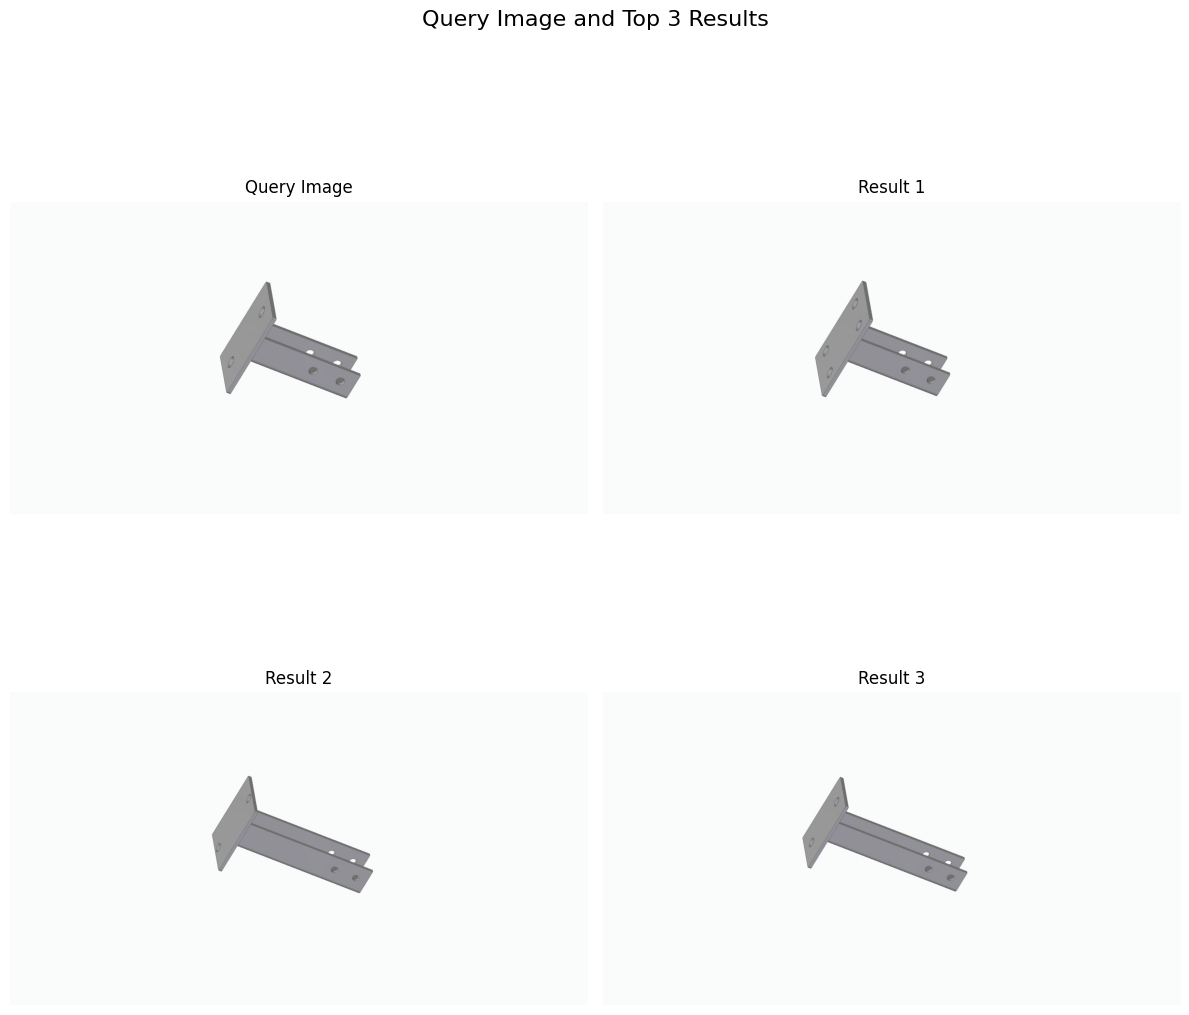

Query results for C:\Users\wanghanyu\Desktop\5_Classes\Fabricated\Fabricated_1.jpg: {'ids': ['1505', '1467', '85'], 'uris': ['C:\\Users\\wanghanyu\\Desktop\\5_Classes\\Fabricated\\Fabricated_2356.jpg', 'C:\\Users\\wanghanyu\\Desktop\\5_Classes\\Fabricated\\Fabricated_2321.jpg', 'C:\\Users\\wanghanyu\\Desktop\\5_Classes\\Fabricated\\Fabricated_1076.jpg'], 'distances': [0.003204523352906108, 0.01590397208929062, 0.01851024106144905]}
Encoding image 1: C:\Users\wanghanyu\Desktop\5_Classes\Fabricated\Fabricated_2356.jpg
Encoding image 2: C:\Users\wanghanyu\Desktop\5_Classes\Fabricated\Fabricated_2321.jpg
Encoding image 3: C:\Users\wanghanyu\Desktop\5_Classes\Fabricated\Fabricated_1076.jpg
Checking if the file exists: C:\Users\wanghanyu\Desktop\5_Classes\Forged\Forged_0.jpg
Calling agent to process the file: C:\Users\wanghanyu\Desktop\5_Classes\Forged\Forged_0.jpg


Query results for C:\Users\wanghanyu\Desktop\5_Classes\Forged\Forged_0.jpg: {'ids': ['3392', '3864', '3759'], 'uris': ['C:\\Users\\wanghanyu\\Desktop\\5_Classes\\Forged\\Forged_2251.jpg', 'C:\\Users\\wanghanyu\\Desktop\\5_Classes\\Forged\\Forged_2677.jpg', 'C:\\Users\\wanghanyu\\Desktop\\5_Classes\\Forged\\Forged_2582.jpg'], 'distances': [0.021805044263601303, 0.023116713389754295, 0.02475573495030403]}
Encoding image 1: C:\Users\wanghanyu\Desktop\5_Classes\Forged\Forged_2251.jpg
Encoding image 2: C:\Users\wanghanyu\Desktop\5_Classes\Forged\Forged_2677.jpg
Encoding image 3: C:\Users\wanghanyu\Desktop\5_Classes\Forged\Forged_2582.jpg
Checking if the file exists: C:\Users\wanghanyu\Desktop\5_Classes\Other\Other_0.jpg
Calling agent to process the file: C:\Users\wanghanyu\Desktop\5_Classes\Other\Other_0.jpg


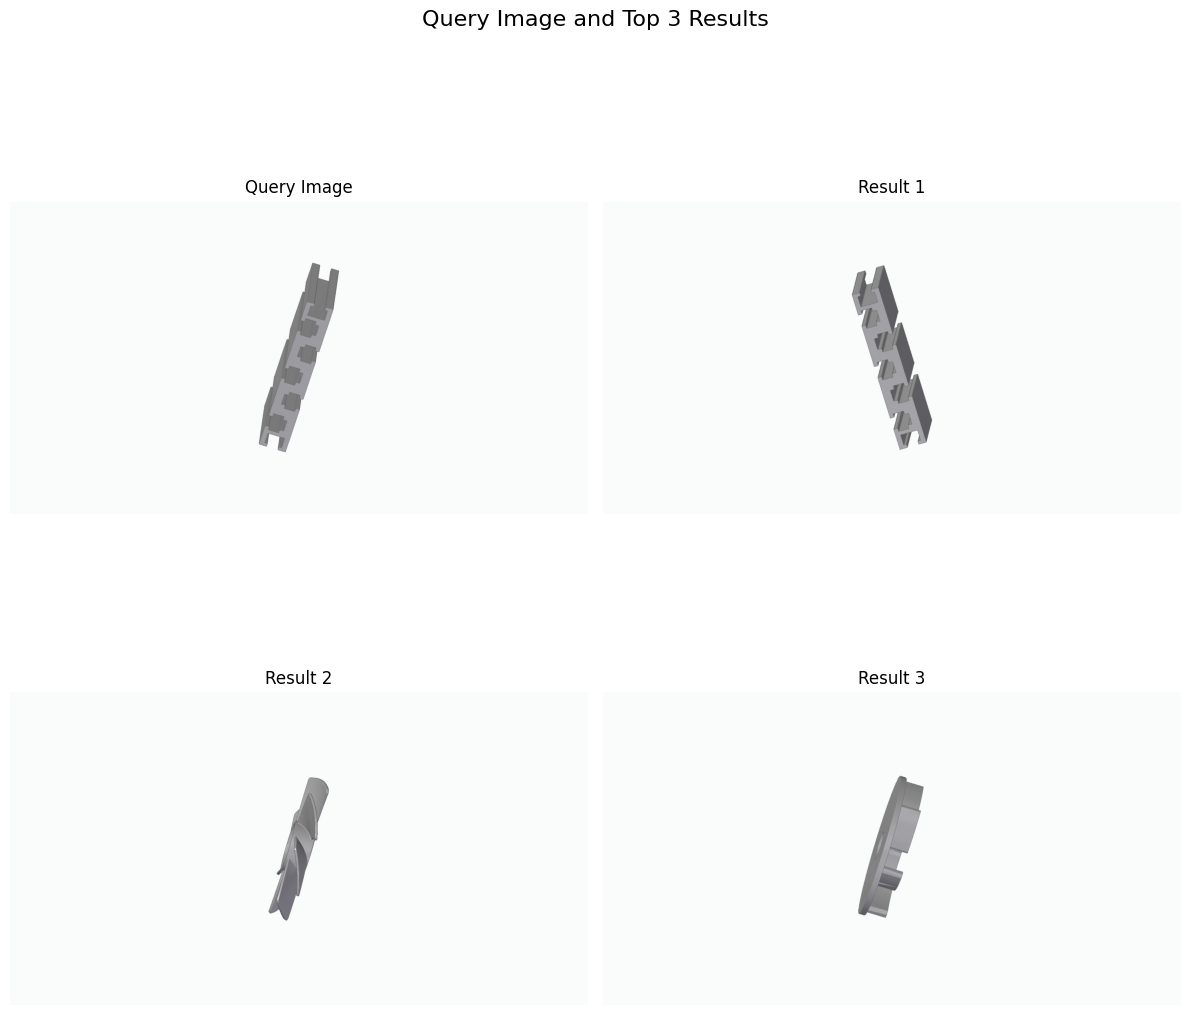

Query results for C:\Users\wanghanyu\Desktop\5_Classes\Other\Other_0.jpg: {'ids': ['5787', '4879', '4314'], 'uris': ['C:\\Users\\wanghanyu\\Desktop\\5_Classes\\Other\\Other_2606.jpg', 'C:\\Users\\wanghanyu\\Desktop\\5_Classes\\Other\\Other_179.jpg', 'C:\\Users\\wanghanyu\\Desktop\\5_Classes\\Other\\Other_1280.jpg'], 'distances': [0.009406105615198612, 0.017658701166510582, 0.01991272158920765]}
Encoding image 1: C:\Users\wanghanyu\Desktop\5_Classes\Other\Other_2606.jpg
Encoding image 2: C:\Users\wanghanyu\Desktop\5_Classes\Other\Other_179.jpg
Encoding image 3: C:\Users\wanghanyu\Desktop\5_Classes\Other\Other_1280.jpg
Checking if the file exists: C:\Users\wanghanyu\Desktop\5_Classes\Sheet Metal\Sheet Metal_1.jpg
Calling agent to process the file: C:\Users\wanghanyu\Desktop\5_Classes\Sheet Metal\Sheet Metal_1.jpg


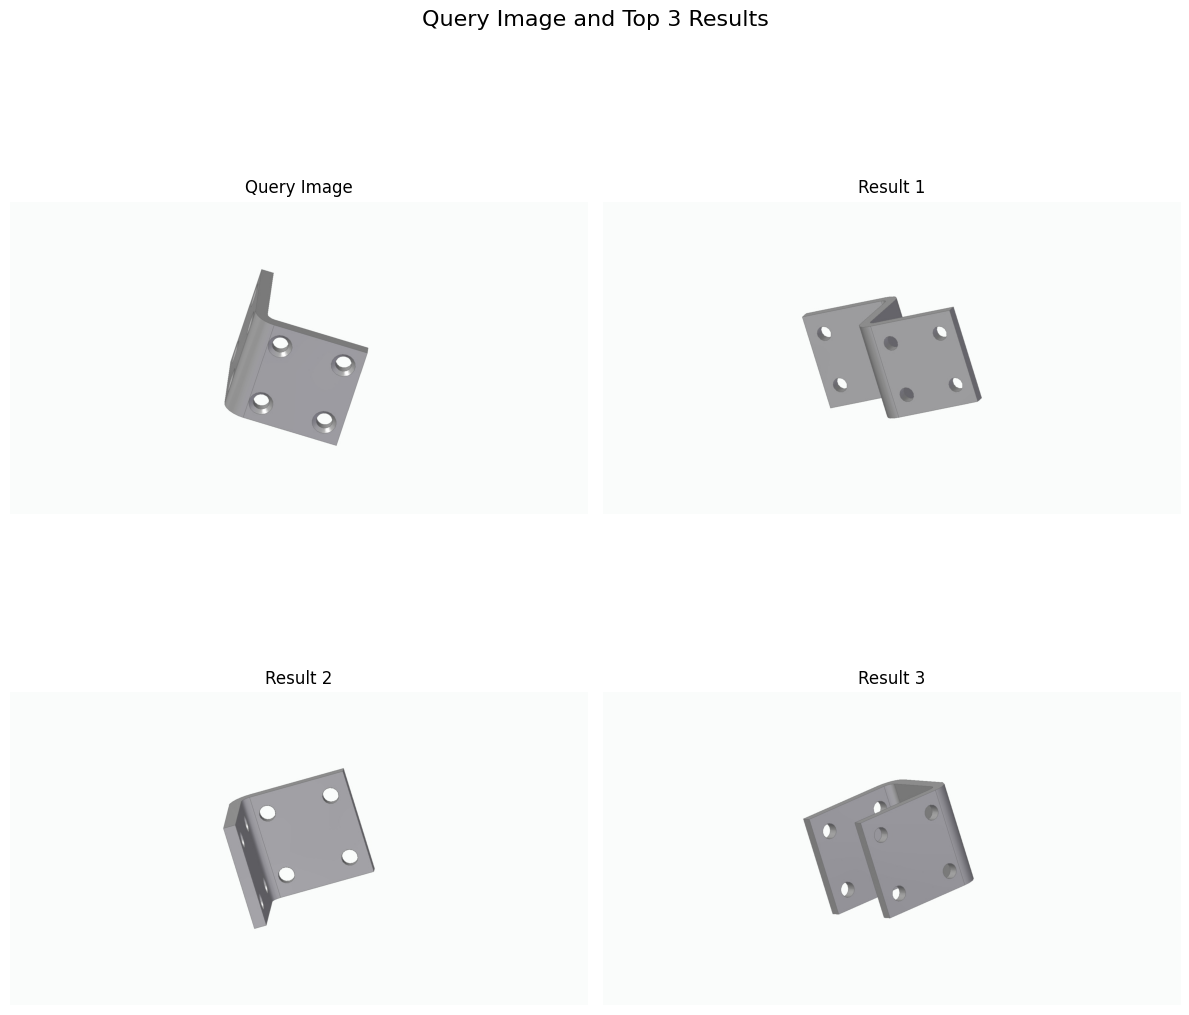

Query results for C:\Users\wanghanyu\Desktop\5_Classes\Sheet Metal\Sheet Metal_1.jpg: {'ids': ['6229', '6686', '6623'], 'uris': ['C:\\Users\\wanghanyu\\Desktop\\5_Classes\\Sheet Metal\\Sheet Metal_1204.jpg', 'C:\\Users\\wanghanyu\\Desktop\\5_Classes\\Sheet Metal\\Sheet Metal_1616.jpg', 'C:\\Users\\wanghanyu\\Desktop\\5_Classes\\Sheet Metal\\Sheet Metal_156.jpg'], 'distances': [0.014269519597291946, 0.014536586590111256, 0.015629060566425323]}
Encoding image 1: C:\Users\wanghanyu\Desktop\5_Classes\Sheet Metal\Sheet Metal_1204.jpg
Encoding image 2: C:\Users\wanghanyu\Desktop\5_Classes\Sheet Metal\Sheet Metal_1616.jpg
Encoding image 3: C:\Users\wanghanyu\Desktop\5_Classes\Sheet Metal\Sheet Metal_156.jpg
Checking if the file exists: C:\Users\wanghanyu\Desktop\5_Classes\Turned\Turned_1.jpg
Calling agent to process the file: C:\Users\wanghanyu\Desktop\5_Classes\Turned\Turned_1.jpg


Query results for C:\Users\wanghanyu\Desktop\5_Classes\Turned\Turned_1.jpg: {'ids': ['9915', '9739', '9825'], 'uris': ['C:\\Users\\wanghanyu\\Desktop\\5_Classes\\Turned\\Turned_2722.jpg', 'C:\\Users\\wanghanyu\\Desktop\\5_Classes\\Turned\\Turned_2564.jpg', 'C:\\Users\\wanghanyu\\Desktop\\5_Classes\\Turned\\Turned_2641.jpg'], 'distances': [0.00038347981171682477, 0.0004268667835276574, 0.0010506269754841924]}
Encoding image 1: C:\Users\wanghanyu\Desktop\5_Classes\Turned\Turned_2722.jpg
Encoding image 2: C:\Users\wanghanyu\Desktop\5_Classes\Turned\Turned_2564.jpg
Encoding image 3: C:\Users\wanghanyu\Desktop\5_Classes\Turned\Turned_2641.jpg
CSV file saved at: d:\Microsoft VS Code\RAG_PCA_vector.csv
Fabricated_1.jpg: The primary manufacturing method used to produce this component is welding, and its key features include a flat mounting plate with multiple holes and a perpendicular bracket with additional holes for attachment.
Forged_0.jpg: The primary manufacturing method for this componen

In [10]:
results = process_directories(local_image_dirs)
for result in results:
    print(f"{result['image_name']}: {result['description']}")